### Projet : Churn Prediction

- Problème business:

    - Prédire si un client se désarbonne ou pas

- Fichier Plat (csv)

- Variables
    - Quantitative: 
        - 15 variables
        - 
    - Qualitative: 
        - 6 variables,
        
        - La cible **Attrition_Flag** est de type binaire,
        
        - Le nombre de modalité élevée est de 6 (Income_Category, Education_Level)
        

### Librairie

In [590]:
# Calcul et Traitement de données
import numpy as np
import pandas as pd



# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns


# Avertissement
import warnings
warnings.filterwarnings("ignore")

# Test de chi2
from scipy.stats import chi2_contingency
# Normalisation et Encodage
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# split du jeu de donnée
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_selection import chi2, f_oneway, SelectKBest, f_classif
from scipy.stats import ttest_ind

# Model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import pickle

### Chargement des données

In [2]:
data = pd.read_csv('Dataset.csv', sep=";", na_values='Unknown')

In [761]:
df = data.copy()
df.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School            NaN  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
0              39                         5                       1   
1              44                         6                       1   
2              36                         4                       1   
3              34                         3                       4   
4              21                         5                       1   

   Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  \
0                      3       12691.0                  777          11914.0   
1                      2        8256.0                  864           7392.0   
2                      0        3418.0                    0           3418.0   
3                      1        3313.0                 2517            796.0   
4                      0        4716.0                    0           4716.0   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0                 1.335             1144              42                1.625   
1                 1.541             1291              33                3.714   
2                 2.594             1887              20                2.333   
3                 1.405             1171              20                2.333   
4                 2.175              816              28                2.500   

   Avg_Utilization_Ratio  
0                  0.061  
1                  0.105  
2                  0.000  
3                  0.760  
4                  0.000

### Analyse Exploratoire

In [84]:
df.shape

(10127, 21)

In [4]:
(df.isna().sum()/df.shape[0]).sort_values()

CLIENTNUM                   0.000000
Total_Trans_Ct              0.000000
Total_Trans_Amt             0.000000
Total_Amt_Chng_Q4_Q1        0.000000
Avg_Open_To_Buy             0.000000
Total_Revolving_Bal         0.000000
Credit_Limit                0.000000
Contacts_Count_12_mon       0.000000
Months_Inactive_12_mon      0.000000
Total_Ct_Chng_Q4_Q1         0.000000
Total_Relationship_Count    0.000000
Card_Category               0.000000
Dependent_count             0.000000
Gender                      0.000000
Customer_Age                0.000000
Attrition_Flag              0.000000
Months_on_book              0.000000
Avg_Utilization_Ratio       0.000000
Marital_Status              0.073961
Income_Category             0.109805
Education_Level             0.149995
dtype: float64

In [781]:
df.duplicated().sum()

0

- Valeurs manquantes dans 3 variables
    - Marital_Status;
    - Income_Category;
    - Education_Level à le plus grand avec **15%** 

In [85]:
for col in df.select_dtypes(object):
    print(f"{col :-<50} {df[col].unique()}")

Attrition_Flag------------------------------------ ['Existing Customer' 'Attrited Customer']
Gender-------------------------------------------- ['M' 'F']
Education_Level----------------------------------- ['High School' 'Graduate' 'Uneducated' nan 'College' 'Post-Graduate'
 'Doctorate']
Marital_Status------------------------------------ ['Married' 'Single' nan 'Divorced']
Income_Category----------------------------------- ['$60K - $80K' 'Less than $40K' '$80K - $120K' '$40K - $60K' '$120K +' nan]
Card_Category------------------------------------- ['Blue' 'Gold' 'Silver' 'Platinum']


- 6 variables Qualitatives,
    
- La cible **Attrition_Flag** est de type binaire,
    
- Le nombre de modalité élevée est de 6 (Income_Category, Education_Level)

#### Nombre de modalité par variable qualitative

In [6]:
df.select_dtypes(object).nunique().sort_values()

Attrition_Flag     2
Gender             2
Marital_Status     3
Card_Category      4
Income_Category    5
Education_Level    6
dtype: int64

#### Description des variables quantitatives

In [7]:
df.drop('CLIENTNUM', axis=1).describe()

Customer_Age  Dependent_count  Months_on_book  \
count  10127.000000     10127.000000    10127.000000   
mean      46.325960         2.346203       35.928409   
std        8.016814         1.298908        7.986416   
min       26.000000         0.000000       13.000000   
25%       41.000000         1.000000       31.000000   
50%       46.000000         2.000000       36.000000   
75%       52.000000         3.000000       40.000000   
max       73.000000         5.000000       56.000000   

       Total_Relationship_Count  Months_Inactive_12_mon  \
count              10127.000000            10127.000000   
mean                   3.812580                2.341167   
std                    1.554408                1.010622   
min                    1.000000                0.000000   
25%                    3.000000                2.000000   
50%                    4.000000                2.000000   
75%                    5.000000                3.000000   
max                    6.000000                6.000000   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
count           10127.000000  10127.000000         10127.000000   
mean                2.455317   8631.953698          1162.814061   
std                 1.106225   9088.776650           814.987335   
min                 0.000000   1438.300000             0.000000   
25%                 2.000000   2555.000000           359.000000   
50%                 2.000000   4549.000000          1276.000000   
75%                 3.000000  11067.500000          1784.000000   
max                 6.000000  34516.000000          2517.000000   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
count     10127.000000          10127.000000     10127.000000    10127.000000   
mean       7469.139637              0.759941      4404.086304       64.858695   
std        9090.685324              0.219207      3397.129254       23.472570   
min           3.000000              0.000000       510.000000       10.000000   
25%        1324.500000              0.631000      2155.500000       45.000000   
50%        3474.000000              0.736000      3899.000000       67.000000   
75%        9859.000000              0.859000      4741.000000       81.000000   
max       34516.000000              3.397000     18484.000000      139.000000   

       Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
count         10127.000000           10127.000000  
mean              0.712222               0.274894  
std               0.238086               0.275691  
min               0.000000               0.000000  
25%               0.582000               0.023000  
50%               0.702000               0.176000  
75%               0.818000               0.503000  
max               3.714000               0.999000

#### Âge

- La plupart des individus ont 46 ans;
- Le plus jeune a 26 ans tandis que le plus vieux à 73;
- L'écart entre chacun des individus et la l'âge moyen est faibles
- 50% des individus ont 46 (Âge moyen = Mediane; la distribution de l'âge est probablement normale);

#### Months_on_book

- La plupart des personnes ont une relation de 36 mois de temps avec la banque,
- La durée de relation avec banque la plus petite est de 13 mois tandis que le plus grand temps est de 56 mois.
- 50% des individus ont une relation de temps de 36 mois avec banque (temps moyen = Mediane; la distribution semble être normale)
- L'écart entre chacun des individus et la moyenne de temps est faibles

### Analyse univariée

#### Cible

In [8]:
df['Attrition_Flag'].value_counts(normalize=True)*100

Existing Customer    83.934038
Attrited Customer    16.065962
Name: Attrition_Flag, dtype: float64

- Classe désequilibrée => La bonne métrique ne sera pas l'accuracy.
- On prendra le score f1/recall comme métrique [**Pour plus d'info cliquer**](https://www.quantmetry.com/blog/classification-et-desequilibre-de-classes/)
- 14% des gens ne se désarbonne pas

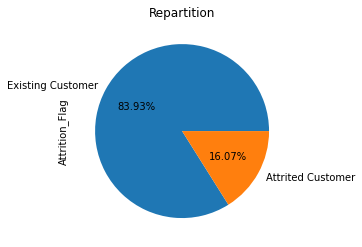

In [9]:
plt.figure()
plt.title('Repartition')
df['Attrition_Flag'].value_counts().plot.pie(autopct='%.2f%%');

#### Variable quali

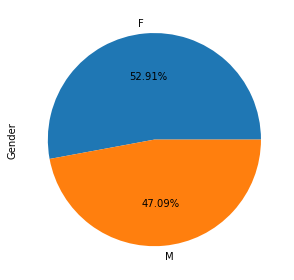

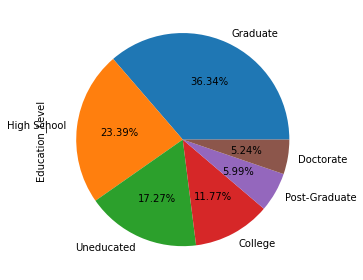

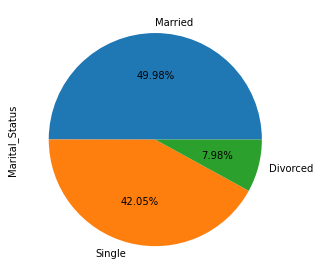

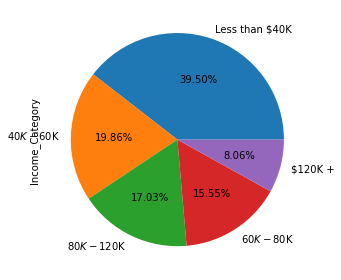

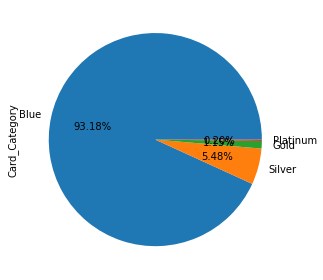

In [10]:
for col in df.select_dtypes(object):
    if col not in 'Attrition_Flag':
        plt.figure()
        df[col].value_counts().plot.pie(autopct='%1.2f%%')
        plt.tight_layout()

- Le Genre semble être équilibré
- La plupart des personnes ont un diplôme supérieur à la licence soit 36% des individus
- Y a plus autant de personnes mariées que de célibataire
- Le revenue annuel est généralement inférieur à la 40000
- La carte blue est la carte de pratiquement tous les individus soit 93% des individus

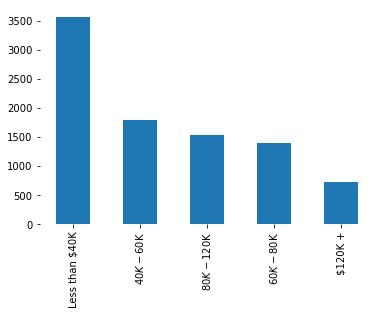

In [11]:
df['Income_Category'].value_counts().plot.bar()
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

- Le revenu annuel est généralement inférieur 40k

#### Variable quantitative

In [65]:
df.select_dtypes(np.number).nunique().sort_values()

Dependent_count                 6
Total_Relationship_Count        6
Months_Inactive_12_mon          7
Contacts_Count_12_mon           7
Months_on_book                 44
Customer_Age                   45
Total_Trans_Ct                126
Total_Ct_Chng_Q4_Q1           830
Avg_Utilization_Ratio         964
Total_Amt_Chng_Q4_Q1         1158
Total_Revolving_Bal          1974
Total_Trans_Amt              5033
Credit_Limit                 6205
Avg_Open_To_Buy              6813
CLIENTNUM                   10127
dtype: int64

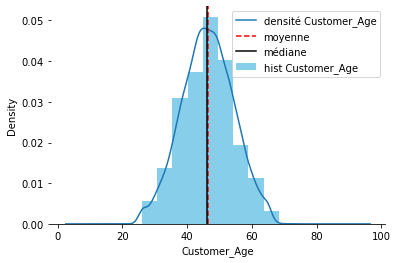

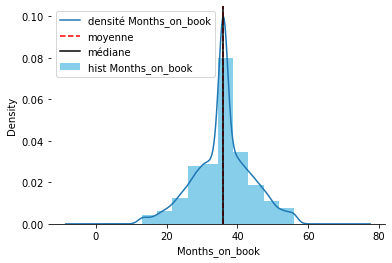

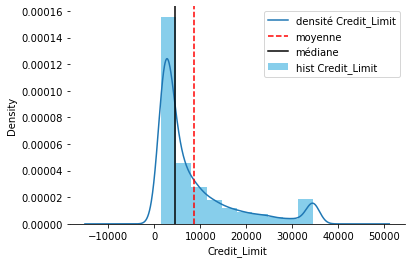

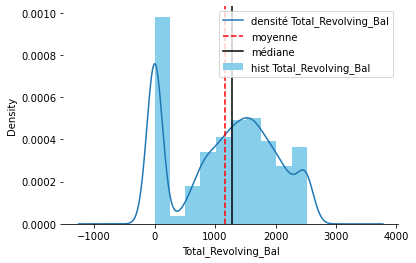

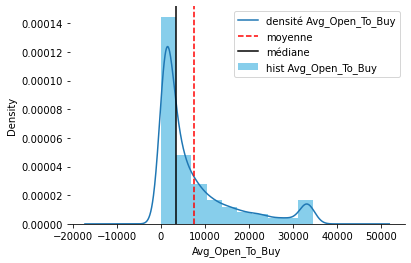

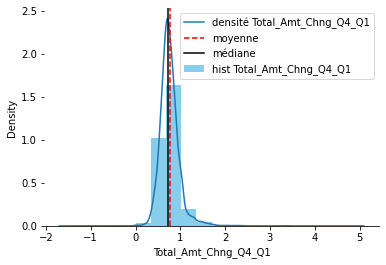

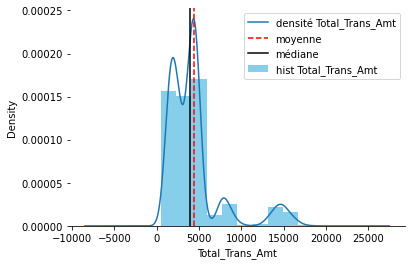

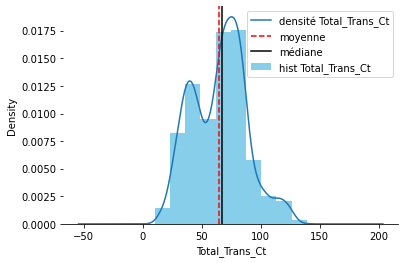

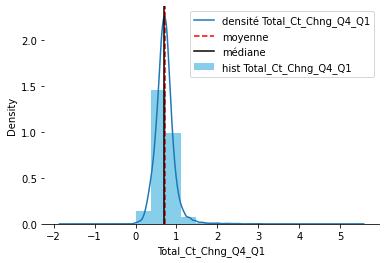

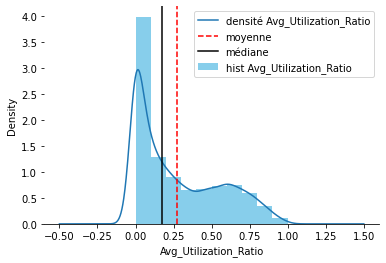

In [94]:
for col in df.select_dtypes(np.number):
    if col not in 'CLIENTNUM' and df[col].nunique() > 7:
        
        plt.figure()
        plt.hist(df[col], bins=10, density=True, label= 'hist '+col, color='skyblue')
        df[col].plot(kind ="density", label = 'densité ' + col)
        plt.xlabel(col)
        plt.axvline(x = df[col].mean(), c ='r', label='moyenne', linestyle="--")
        plt.axvline(x = df[col].median(), c ='black', label='médiane')
        plt.legend()
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)

- La distribution semble normale pour les variables: Customer age, Month_on_book, Total Ct_Chng_Q4_Q1, Total_Trans_Ct
- Credit Limit: distribution étalée à droite

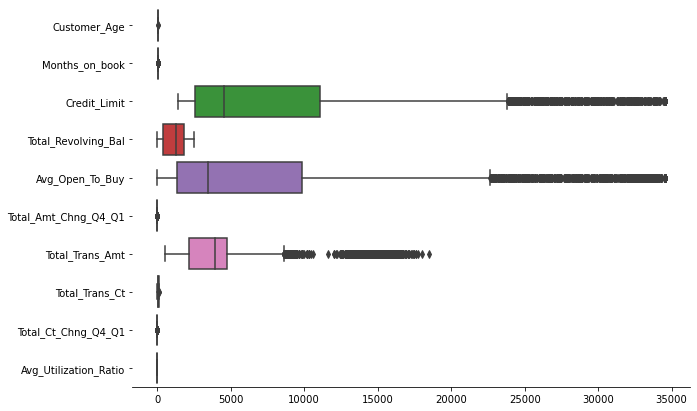

In [29]:
plt.figure(figsize=(10, 7))
sns.boxplot(data = df[[col for col in df.select_dtypes(np.number) if col not in 'CLIENTNUM' and df[col].nunique() > 7]], orient='h')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False);

- Echelle différente 
- Valeurs aberrantes pour les variables Credit Limit, Avg_Open_To_Buy et Total_Trans_Amot => Le robust scaler comme normalisation

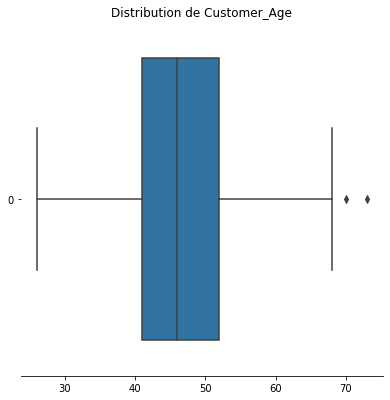

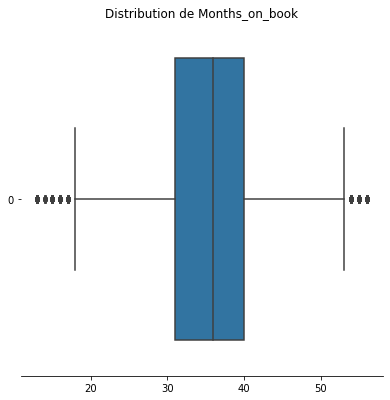

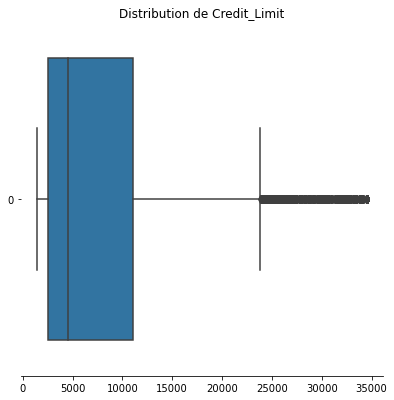

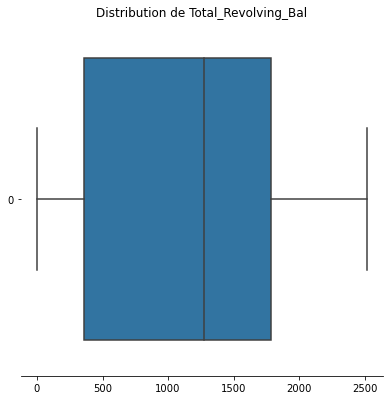

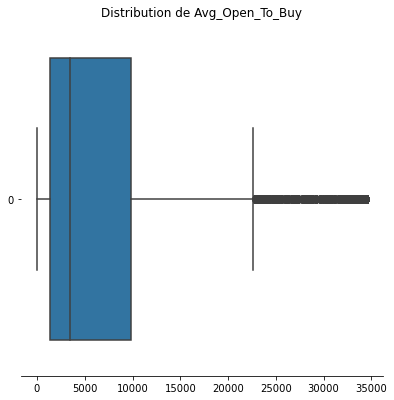

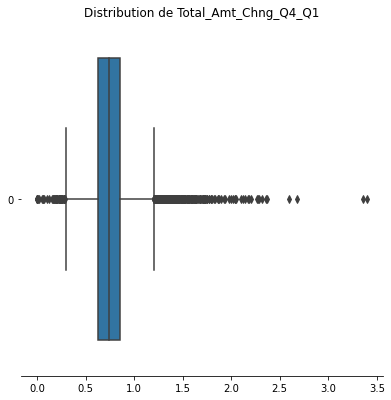

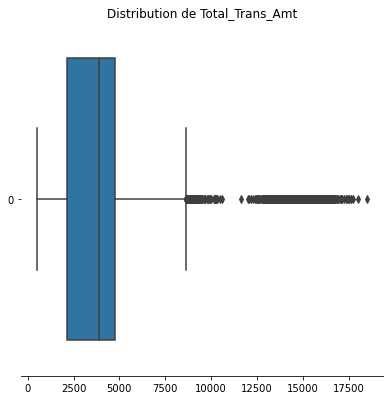

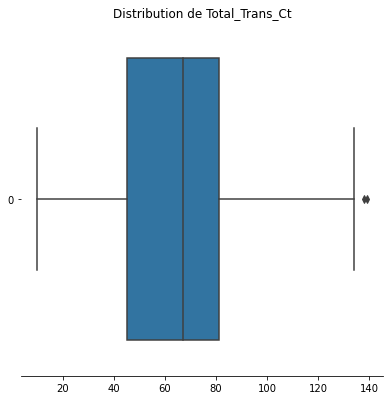

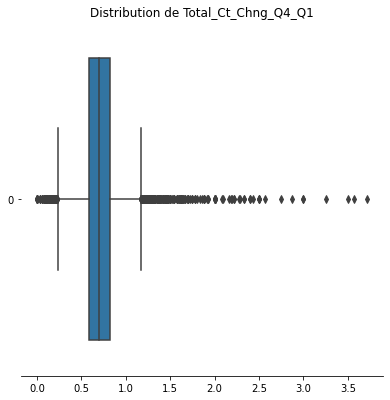

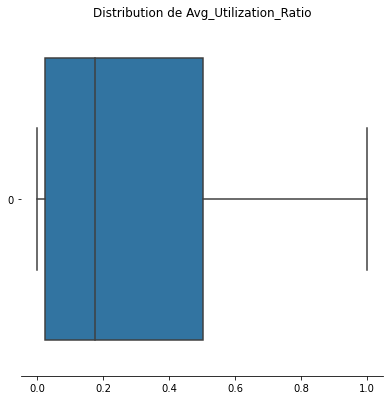

In [33]:
for col in df.select_dtypes(np.number):
    if col not in 'CLIENTNUM' and df[col].nunique() > 7:
        plt.figure(figsize=(6.5, 6.5))
        plt.title("Distribution de " + col)
        sns.boxplot(data=df[col], orient='h', )
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.gca().spines['left'].set_visible(False);

- Plusieurs valeurs aberrantes dans plus de 50% des varaibles quantitatives

### Analyse bivariée

#### Cible et Qualitative

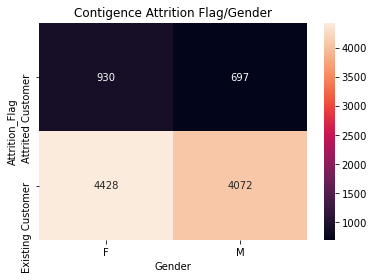

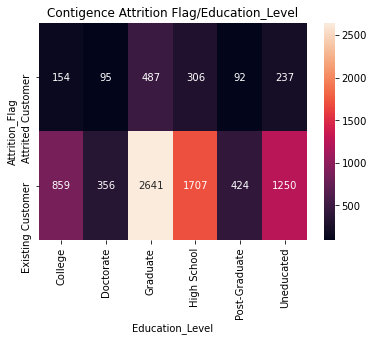

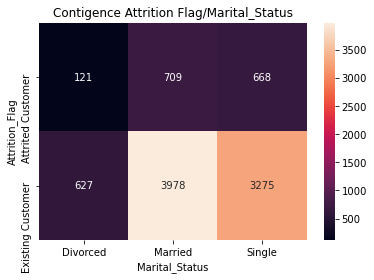

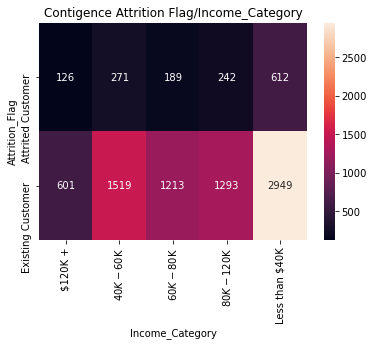

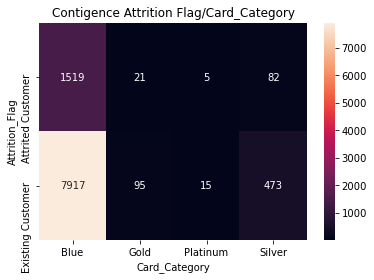

In [113]:
for col in df.select_dtypes(object):
    if col not in 'Attrition_Flag':
        plt.figure()
        plt.title('Contigence Attrition Flag/' + col)
        sns.heatmap(pd.crosstab(df['Attrition_Flag'], df[col]), fmt = 'd', annot=True)

- La plupart des variables qualitatives ne nous donnes pas assez d'information pour décider si un individu va ou reste;

**NB : Le test de khi-2 sera appropié pour verifier l'indépendence entre nos variables et la cible**

#### Relation Quantitative/Cible

In [34]:
df['Attrition_Flag'].unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

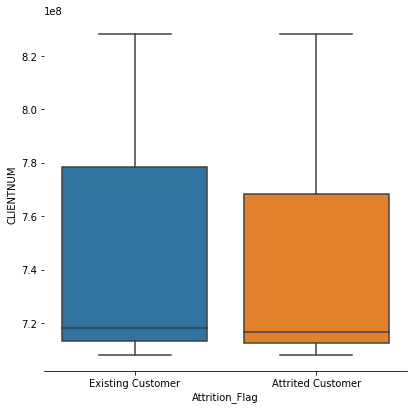

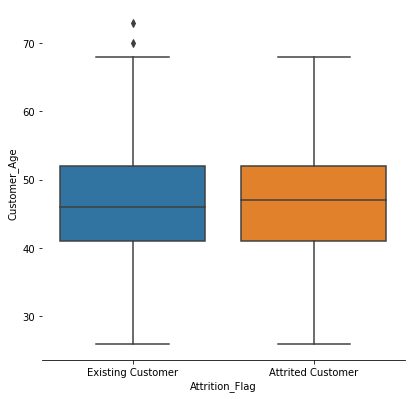

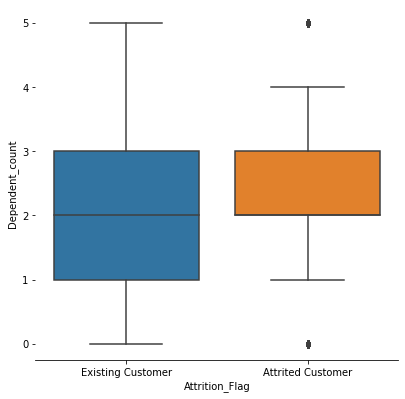

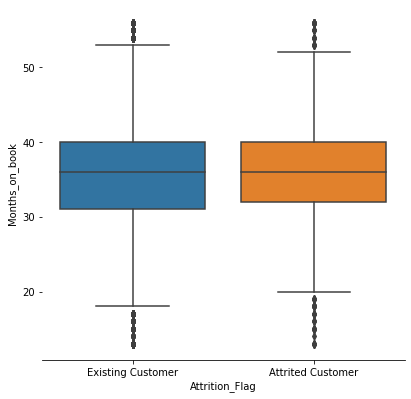

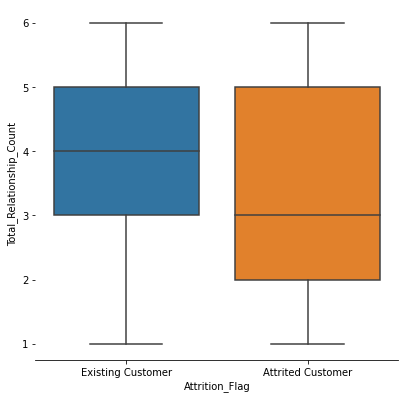

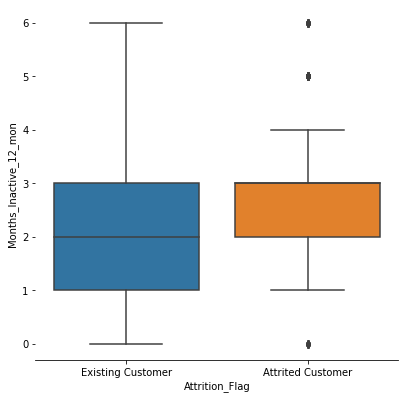

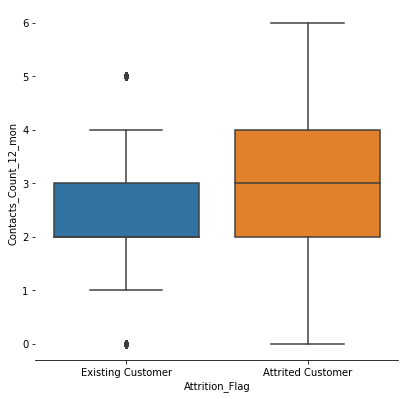

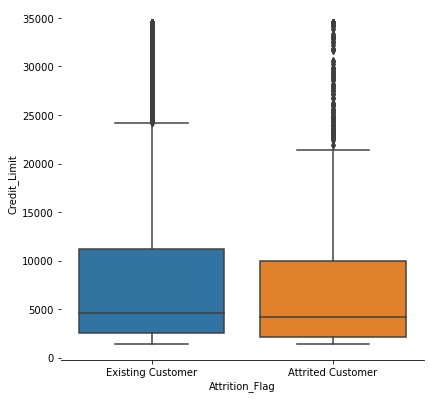

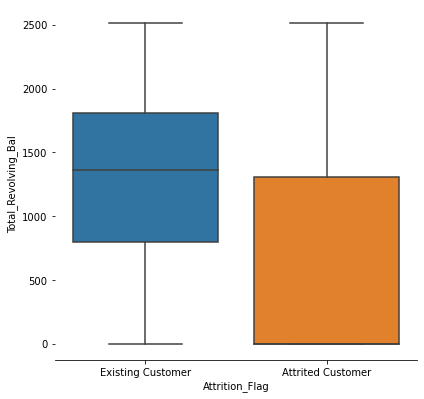

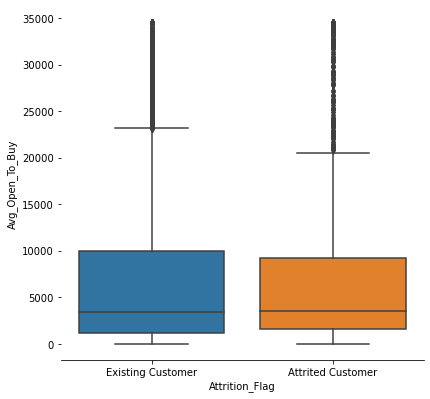

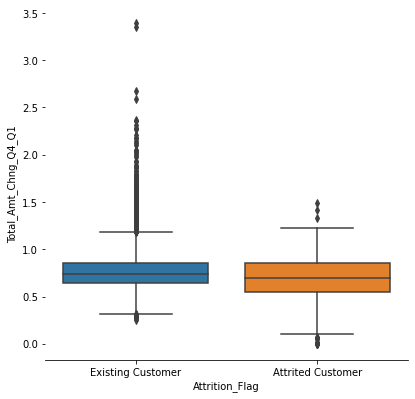

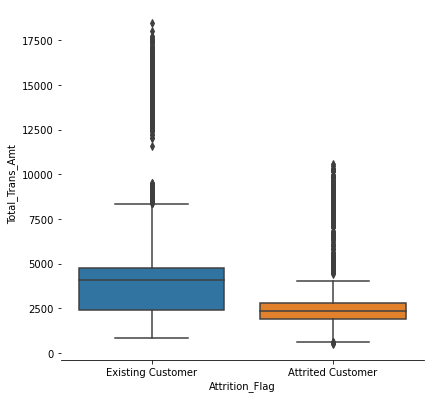

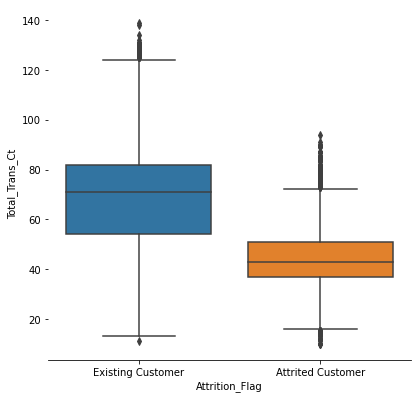

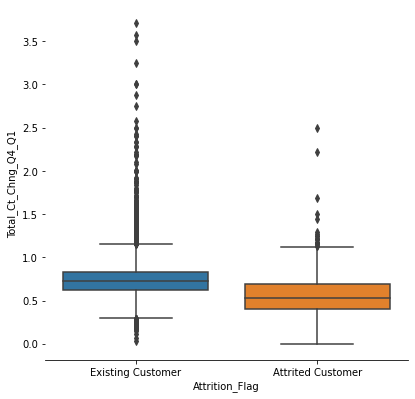

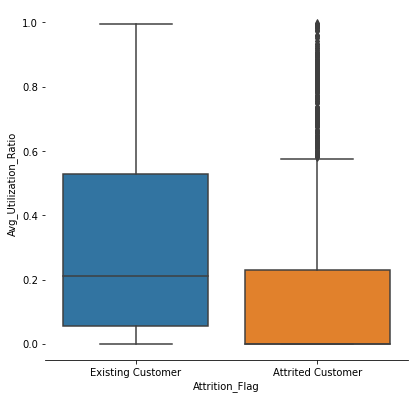

In [45]:
for col in df.select_dtypes(np.number).columns:
    
    plt.figure(figsize=(6.5, 6.5))
    sns.boxplot(x = 'Attrition_Flag', y = col, data=df)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False);

In [49]:
Existing_df = df[df['Attrition_Flag'] == 'Existing Customer']
Attrited_df = df[df['Attrition_Flag'] == 'Attrited Customer']

#### Quantitative continue

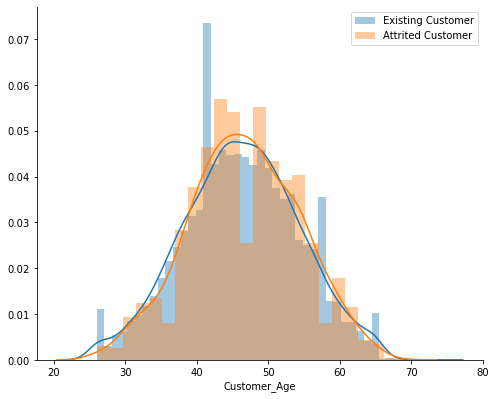

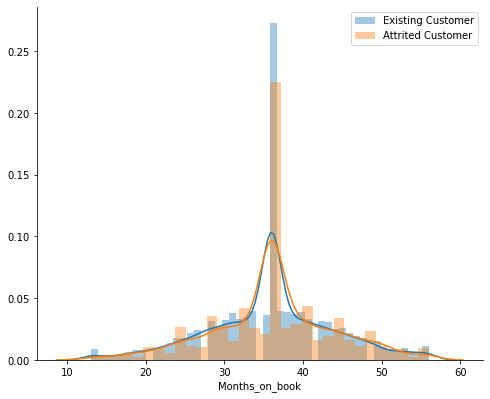

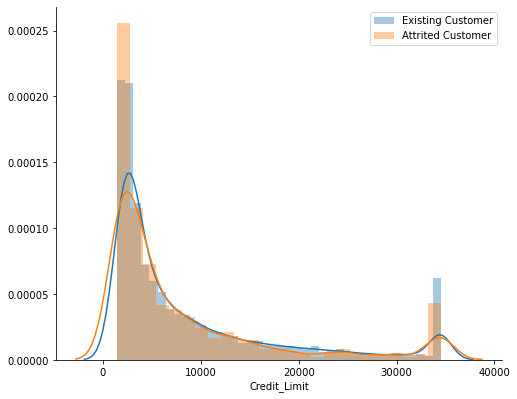

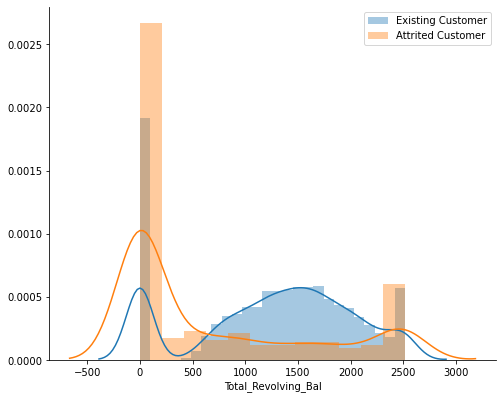

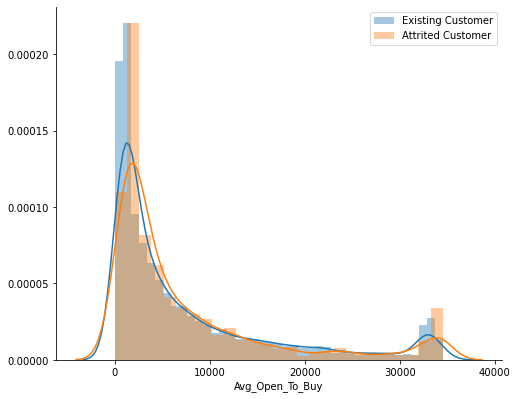

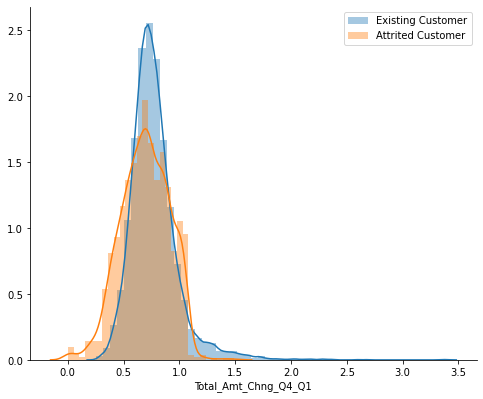

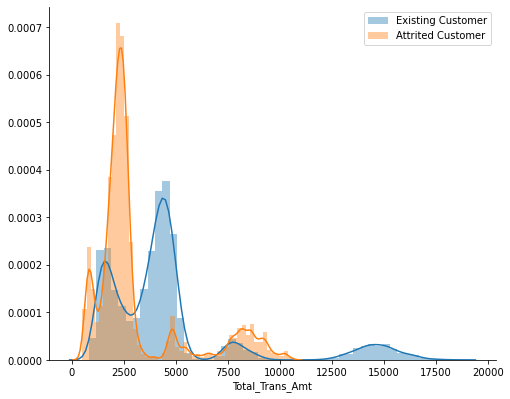

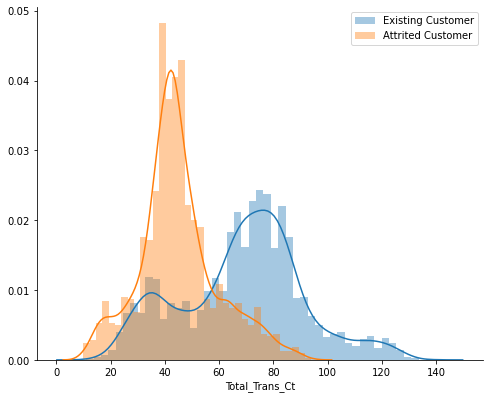

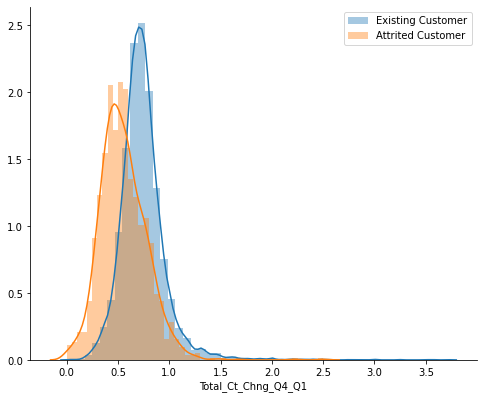

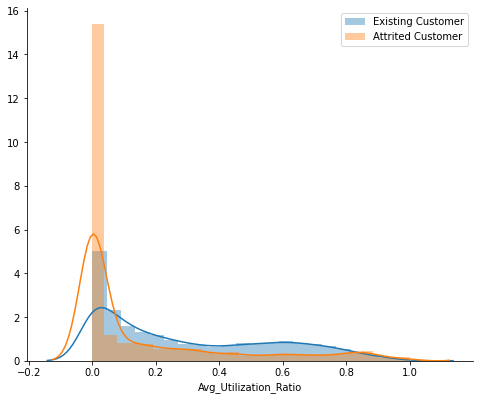

In [67]:
for col in [col for col in df.select_dtypes(np.number) if col not in 'CLIENTNUM' and df[col].nunique() >7]:
        plt.figure(figsize=(8, 6.5))
        sns.distplot(Existing_df[col], label = 'Existing Customer')
        sns.distplot(Attrited_df[col], label = 'Attrited Customer')
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)
        plt.legend()

- Il semble avoir un lien entre: 
    - Le Solde renouvelable total sur la carte de crédit (Total Resolving Bal) et Le fait que les personnes se désabonnent;
    
    - Le Montant total de la transaction sur les 12 derniers mois ( Total_Trans_Amt) et le fait que les personnes se désabonnent;
    
    - Nombre total de transactions 12 derniers mois/Total_Trans_Ct et le fait que les personnes se désabonnent
    
    - Le Changement du nombre de transactions (T4 par rapport au T1)/(Total_Ct_Chng_Q4_Q1) et le fait qu'un individu parte,

**NB : Nous allons tester ces observations pour être plus robuste**

#### Quantitative discretes

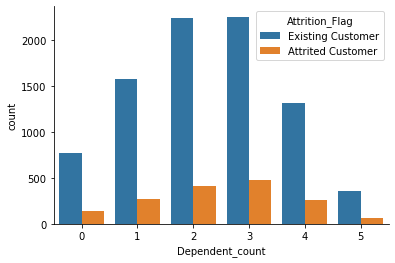

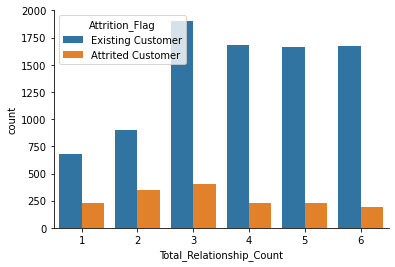

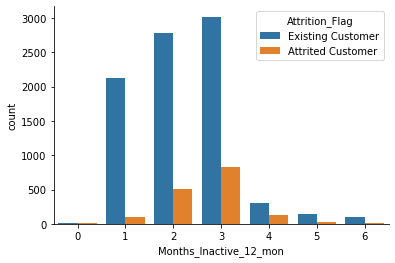

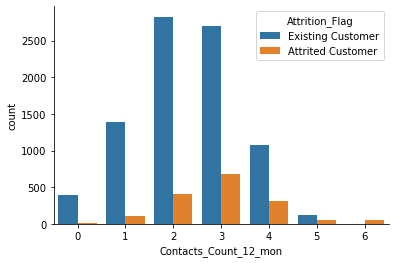

In [83]:
for col in [col for col in df.select_dtypes(np.number) if col not in 'CLIENTNUM' and df[col].nunique() <= 15]:
    plt.figure()
    sns.countplot(x = col, hue = 'Attrition_Flag', data=df)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)

**Les Variables quantitatives semblent avoir plus de liens avec la cible contrairement aux variables qualitatives.**

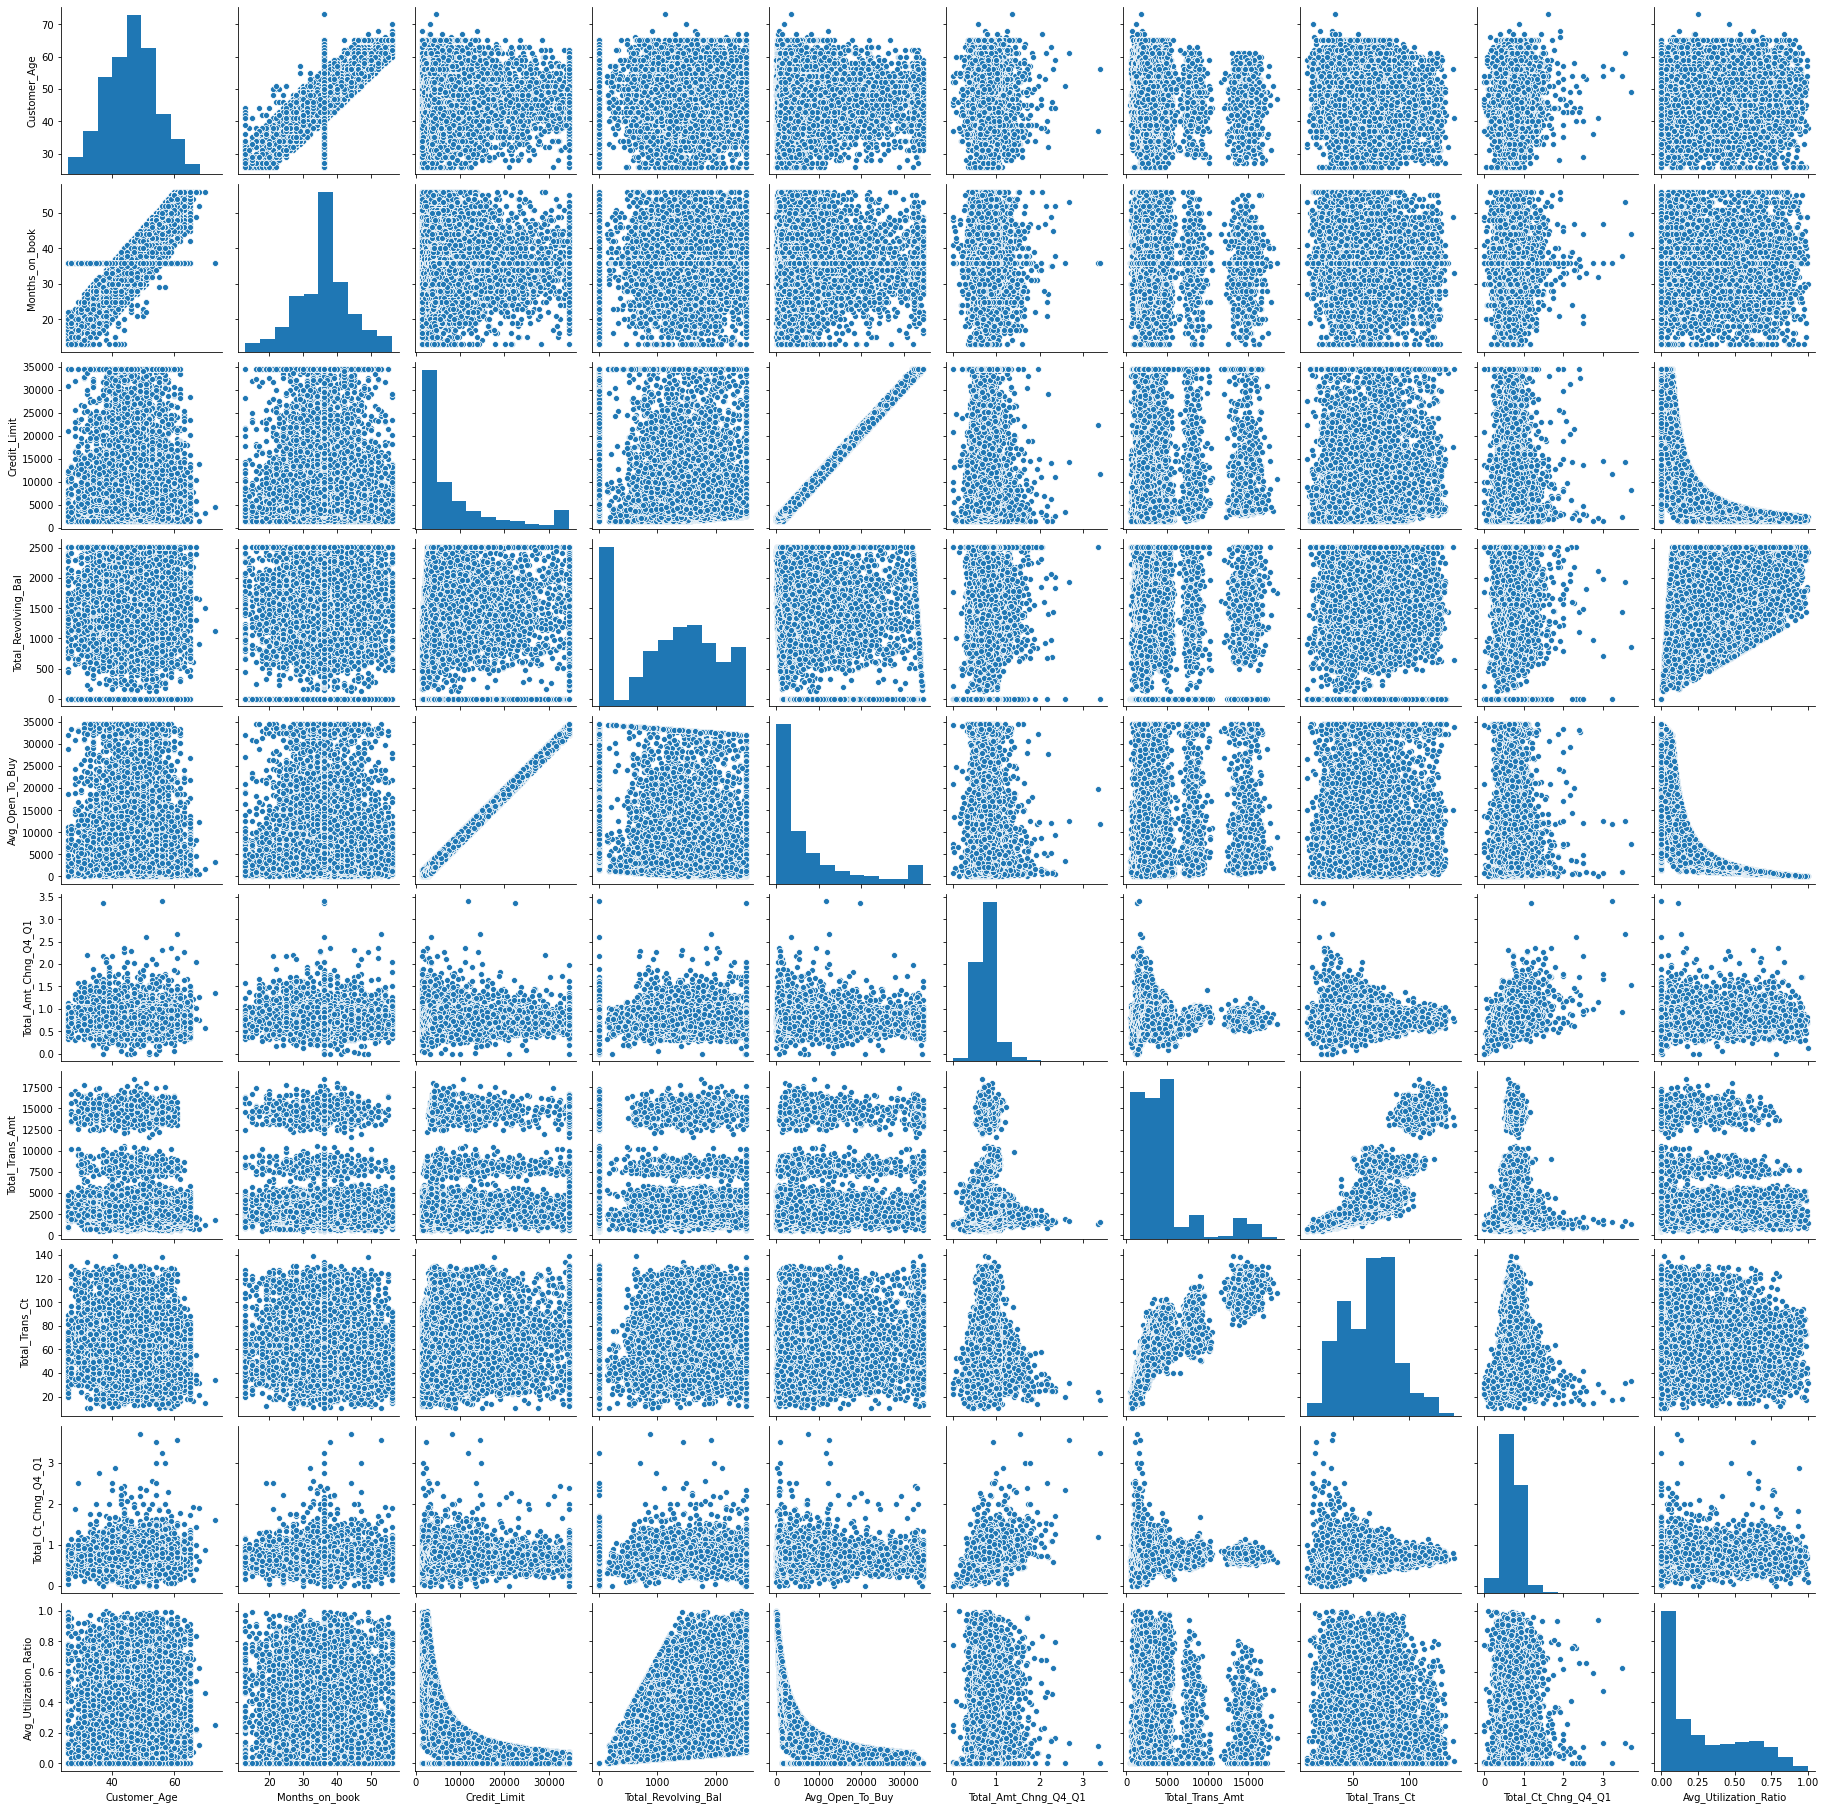

In [15]:
sns.pairplot(df[[col for col in df.select_dtypes(np.number) if col not in 'CLIENTNUM' and df[col].nunique() >7]], hue=);

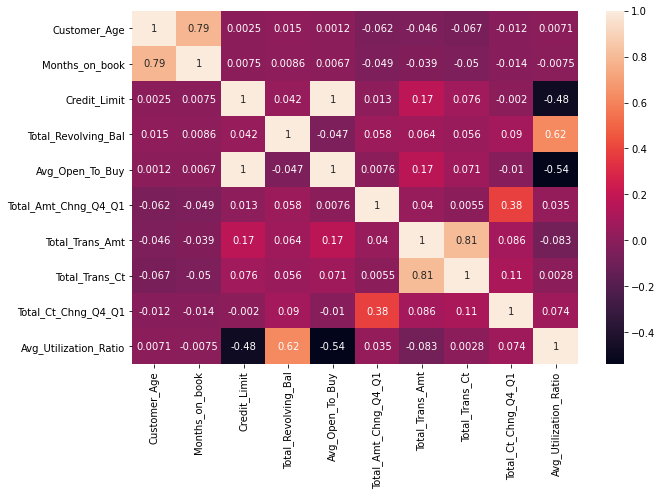

In [23]:
plt.figure(figsize=(10, 6.5))
sns.heatmap(df[[col for col in df.select_dtypes(np.number) if col not in 'CLIENTNUM' and df[col].nunique() >7]].corr(), annot=True);

- Très forte correlation Linéaire entre La limite de Credit et la Ligne de crédit ouverte à l'achat (moyenne des 12 derniers mois)

- Forte Correlation Linéaire (positive) entre l'âge du client et le temps de sa relation avec la banque (0.79)
- Forte Correlation Linéaire (positive) entre le Montant total de la transaction (12 derniers mois) et le Nombre total de transactions (12 derniers mois) (0.81)

In [36]:
df[[col for col in df.select_dtypes(np.number) if col not in 'CLIENTNUM' and df[col].nunique() >7]].corr()['Credit_Limit'].sort_values(ascending=False)

Credit_Limit             1.000000
Avg_Open_To_Buy          0.995981
Total_Trans_Amt          0.171730
Total_Trans_Ct           0.075927
Total_Revolving_Bal      0.042493
Total_Amt_Chng_Q4_Q1     0.012813
Months_on_book           0.007507
Customer_Age             0.002476
Total_Ct_Chng_Q4_Q1     -0.002020
Avg_Utilization_Ratio   -0.482965
Name: Credit_Limit, dtype: float64

In [37]:
df[[col for col in df.select_dtypes(np.number) if col not in 'CLIENTNUM' and df[col].nunique() >7]].corr()['Total_Trans_Amt'].sort_values(ascending=False)

Total_Trans_Amt          1.000000
Total_Trans_Ct           0.807192
Credit_Limit             0.171730
Avg_Open_To_Buy          0.165923
Total_Ct_Chng_Q4_Q1      0.085581
Total_Revolving_Bal      0.064370
Total_Amt_Chng_Q4_Q1     0.039678
Months_on_book          -0.038591
Customer_Age            -0.046446
Avg_Utilization_Ratio   -0.083034
Name: Total_Trans_Amt, dtype: float64

### Test statistique

In [43]:
chi2_contingency(pd.crosstab(df['Gender'], df['Attrition_Flag']))

(13.86561370063734,
 0.00019635846717310307,
 1,
 array([[ 860.81425891, 4497.18574109],
        [ 766.18574109, 4002.81425891]]))

In [14]:
tab = pd.crosstab(df['Attrition_Flag'], df['Gender'])

In [7]:
chi2_contingency(tab)

(13.86561370063734,
 0.00019635846717310307,
 1,
 array([[ 860.81425891, 4497.18574109],
        [ 766.18574109, 4002.81425891]]))

In [4]:
def test_chi2(V1, V2, alpha):
    
    V2 = df['Attrition_Flag']
    
    cont_tab = pd.crosstab(V1, V2)
    
    khi2 = chi2_contingency(cont_tab)
    pvalue = khi2[1]
    
    if pvalue < alpha:
        return "H0 rejeté à " + str(alpha) + "%"
    else:
        return "H0 accepter " + str(alpha) + "%"

In [9]:
for col in df.select_dtypes(object):
    if col != 'Attrition_Flag':
        print(col)
        print(test_chi2(df['Attrition_Flag'], df[col], alpha=.05) + "\n")

Gender
H0 rejeté à 0.05%

Education_Level
H0 rejeté à 0.05%

Marital_Status
H0 rejeté à 0.05%

Income_Category
H0 rejeté à 0.05%

Card_Category
H0 rejeté à 0.05%



#### Hypothèses
- H0: les caractérique moyens entre les personnes qui se désabonnent et ceux qui ne se désabonnent pas ne sont pas les mêmes,
- H1: 

In [58]:
del Attrited_df['CLIENTNUM']
del Existing_df['CLIENTNUM']

In [59]:
Attrited_df.shape

(1627, 20)

In [60]:
Existing_df.shape

(8500, 20)

In [63]:
Attrition_existing = Existing_df.sample(Attrited_df.shape[0])

In [779]:
def ttest(col):
    
    alpha = 0.05
    
    stat, p = ttest_ind(Attrition_existing[col].dropna(), Attrited_df[col].dropna())
    if p < alpha:
        
        return "H0 rejetée"
    else:
        return 0

In [780]:
for col in df.drop('CLIENTNUM', axis=1).select_dtypes(np.number):
    print(f"{col :-<50} {ttest(col)}")

Customer_Age-------------------------------------- H0 rejetée
Dependent_count----------------------------------- 0
Months_on_book------------------------------------ 0
Total_Relationship_Count-------------------------- H0 rejetée
Months_Inactive_12_mon---------------------------- H0 rejetée
Contacts_Count_12_mon----------------------------- H0 rejetée
Credit_Limit-------------------------------------- H0 rejetée
Total_Revolving_Bal------------------------------- H0 rejetée
Avg_Open_To_Buy----------------------------------- 0
Total_Amt_Chng_Q4_Q1------------------------------ H0 rejetée
Total_Trans_Amt----------------------------------- H0 rejetée
Total_Trans_Ct------------------------------------ H0 rejetée
Total_Ct_Chng_Q4_Q1------------------------------- H0 rejetée
Avg_Utilization_Ratio----------------------------- H0 rejetée


In [778]:
print(p)

2.684137845244787e-46


0

In [12]:
chi2_contingency(pd.crosstab(df['Attrition_Flag'], df['Gender']))[1]

0.00019635846717310269

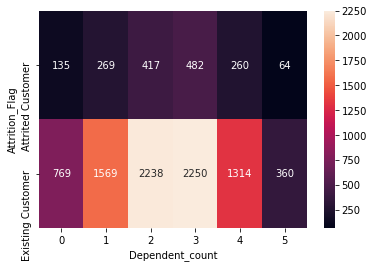

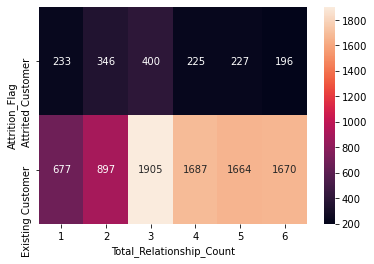

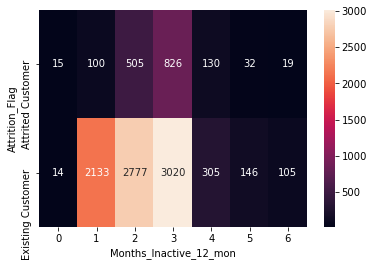

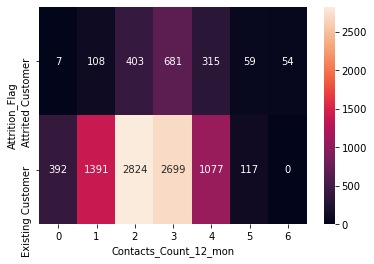

In [21]:
for col in [col for col in df.select_dtypes(np.number) if col not in 'CLIENTNUM' and df[col].nunique() <= 15]:
    plt.figure()
    sns.heatmap(pd.crosstab(df['Attrition_Flag'], df[col]), annot=True, fmt='d')

#### Données manquantes

In [34]:
round(df.dropna().count()/df.shape[0] * 100)

CLIENTNUM                   70.0
Attrition_Flag              70.0
Customer_Age                70.0
Gender                      70.0
Dependent_count             70.0
Education_Level             70.0
Marital_Status              70.0
Income_Category             70.0
Card_Category               70.0
Months_on_book              70.0
Total_Relationship_Count    70.0
Months_Inactive_12_mon      70.0
Contacts_Count_12_mon       70.0
Credit_Limit                70.0
Total_Revolving_Bal         70.0
Avg_Open_To_Buy             70.0
Total_Amt_Chng_Q4_Q1        70.0
Total_Trans_Amt             70.0
Total_Trans_Ct              70.0
Total_Ct_Chng_Q4_Q1         70.0
Avg_Utilization_Ratio       70.0
dtype: float64

### Preprocessing

- Imputation des données manquantes
- Encodage des variables qualitative
- Normalisation des variable quantitative

In [12]:
df1 = data.copy()
df1.head()

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  Education_Level Marital_Status Income_Category Card_Category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School            NaN  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   Months_on_book  ...  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0              39  ...                       1                      3   
1              44  ...                       1                      2   
2              36  ...                       1                      0   
3              34  ...                       4                      1   
4              21  ...                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000  

[5 rows x 21 columns]

In [15]:
del df1['CLIENTNUM']

In [16]:
list_cat = ['Marital_Status', 'Gender', 'Education_Level', 'Income_Category', 'Card_Category']
list_quant = [col for col in df1.select_dtypes(np.number)]
list_quant

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [229]:
pd.set_option('display.max_columns', df.shape[1])

In [248]:
pd.DataFrame([list(client.values())], columns=list(client.keys()))[import_var]

Months_Inactive_12_mon  Contacts_Count_12_mon  Total_Revolving_Bal  \
0                       4                      3                 2540   

   Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  
0                 4.452             1500              33                    2

In [315]:
df2 = data.copy()
df2

CLIENTNUM     Attrition_Flag  Customer_Age Gender  Dependent_count  \
0      768805383  Existing Customer            45      M                3   
1      818770008  Existing Customer            49      F                5   
2      713982108  Existing Customer            51      M                3   
3      769911858  Existing Customer            40      F                4   
4      709106358  Existing Customer            40      M                3   
...          ...                ...           ...    ...              ...   
10122  772366833  Existing Customer            50      M                2   
10123  710638233  Attrited Customer            41      M                2   
10124  716506083  Attrited Customer            44      F                1   
10125  717406983  Attrited Customer            30      M                2   
10126  714337233  Attrited Customer            43      F                2   

      Education_Level Marital_Status Income_Category Card_Category  \
0         High School        Married     $60K - $80K          Blue   
1            Graduate         Single  Less than $40K          Blue   
2            Graduate        Married    $80K - $120K          Blue   
3         High School            NaN  Less than $40K          Blue   
4          Uneducated        Married     $60K - $80K          Blue   
...               ...            ...             ...           ...   
10122        Graduate         Single     $40K - $60K          Blue   
10123             NaN       Divorced     $40K - $60K          Blue   
10124     High School        Married  Less than $40K          Blue   
10125        Graduate            NaN     $40K - $60K          Blue   
10126        Graduate        Married  Less than $40K        Silver   

       Months_on_book  Total_Relationship_Count  Months_Inactive_12_mon  \
0                  39                         5                       1   
1                  44                         6                       1   
2                  36                         4                       1   
3                  34                         3                       4   
4                  21                         5                       1   
...               ...                       ...                     ...   
10122              40                         3                       2   
10123              25                         4                       2   
10124              36                         5                       3   
10125              36                         4                       3   
10126              25                         6                       2   

       Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
0                          3       12691.0                  777   
1                          2        8256.0                  864   
2                          0        3418.0                    0   
3                          1        3313.0                 2517   
4                          0        4716.0                    0   
...                      ...           ...                  ...   
10122                      3        4003.0                 1851   
10123                      3        4277.0                 2186   
10124                      4        5409.0                    0   
10125                      3        5281.0                    0   
10126                      4       10388.0                 1961   

       Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  Total_Trans_Ct  \
0              11914.0                 1.335             1144              42   
1               7392.0                 1.541             1291              33   
2               3418.0                 2.594             1887              20   
3                796.0                 1.405             1171              20   
4               4716.0                 2.175              816              28   
...                ...                   ...     

In [332]:
del df2['CLIENTNUM']

In [256]:
list_cat

['Marital_Status',
 'Gender',
 'Education_Level',
 'Income_Category',
 'Card_Category']

In [257]:
list_quant

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

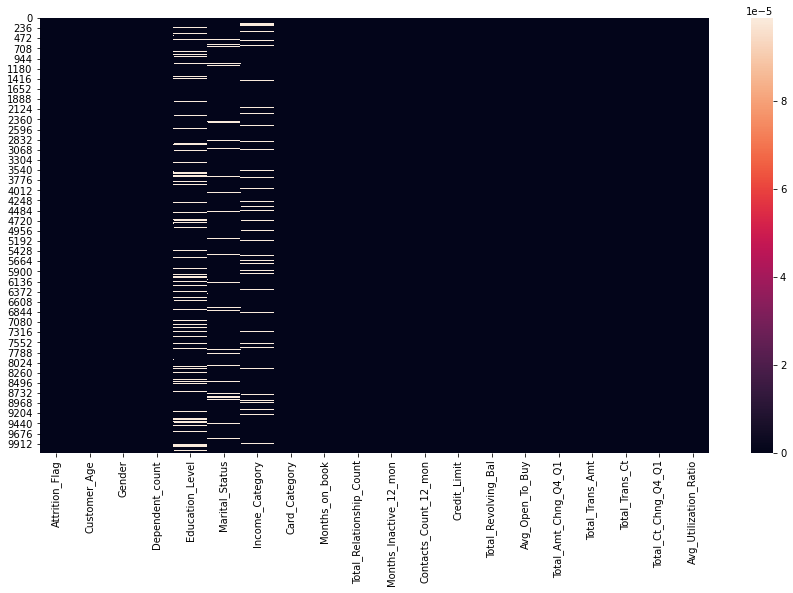

In [367]:
plt.figure(figsize=(15, 8))
sns.heatmap(df2.isna()/df2.shape[0]);

- Les valeurs manquantes ne concernent que des variables catégorielles
    - La première approche d'imputation peut donc être le mode

In [368]:
df2['Education_Level'].value_counts()

Graduate         3128
High School      2013
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education_Level, dtype: int64

In [372]:
df2['Marital_Status'].value_counts()

Married     4687
Single      3943
Divorced     748
Name: Marital_Status, dtype: int64

In [374]:
df2['Income_Category'].value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
$120K +            727
Name: Income_Category, dtype: int64

In [385]:
df

0           $60K - $80K
1        Less than $40K
2          $80K - $120K
3        Less than $40K
4           $60K - $80K
              ...      
10122       $40K - $60K
10123       $40K - $60K
10124    Less than $40K
10125       $40K - $60K
10126    Less than $40K
Name: Income_Category, Length: 10127, dtype: object

##### Valeurs manquantes

In [386]:
def NaN_traitement(df):
    #df.dropna()
    df['Education_Level'] = df['Education_Level'].fillna('Graduate')
    df['Marital_Status']= df['Marital_Status'].fillna('Married')
    df['Income_Category']= df['Income_Category'].fillna('Less than $40K')
    
    return df

In [387]:
df = NaN_traitement(df2)
df.head()

Attrition_Flag  Customer_Age Gender  Dependent_count Education_Level  \
0  Existing Customer            45      M                3     High School   
1  Existing Customer            49      F                5        Graduate   
2  Existing Customer            51      M                3        Graduate   
3  Existing Customer            40      F                4     High School   
4  Existing Customer            40      M                3      Uneducated   

  Marital_Status Income_Category Card_Category  Months_on_book  \
0        Married     $60K - $80K          Blue              39   
1         Single  Less than $40K          Blue              44   
2        Married    $80K - $120K          Blue              36   
3        Married  Less than $40K          Blue              34   
4        Married     $60K - $80K          Blue              21   

   Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                         5                       1                      3   
1                         6                       1                      2   
2                         4                       1                      0   
3                         3                       4                      1   
4                         5                       1                      0   

   Credit_Limit  Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0       12691.0                  777          11914.0                 1.335   
1        8256.0                  864           7392.0                 1.541   
2        3418.0                    0           3418.0                 2.594   
3        3313.0                 2517            796.0                 1.405   
4        4716.0                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1144              42                1.625                  0.061  
1             1291              33                3.714                  0.105  
2             1887              20                2.333                  0.000  
3             1171              20                2.333                  0.760  
4              816              28                2.500                  0.000

In [389]:
df.isna().sum()

Attrition_Flag              0
Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

### Train et Test 

In [646]:
trainset, testset = train_test_split(df, test_size=0.3, random_state=0)

In [649]:
X_train = trainset.drop('Attrition_Flag', axis=1)

In [650]:
y_train = trainset['Attrition_Flag']

In [655]:
X_test = testset.drop('Attrition_Flag', axis=1)

In [657]:
y_test = testset['Attrition_Flag']

In [660]:
X_train.shape

(7088, 19)

In [661]:
X_test.shape

(3039, 19)

In [662]:
y_train.shape

(7088,)

In [663]:
y_test.shape

(3039,)

In [664]:
X_train

Customer_Age Gender  Dependent_count Education_Level Marital_Status  \
4813            47      M                2        Graduate       Divorced   
9887            54      M                1        Graduate         Single   
4191            41      F                4      Uneducated        Married   
7527            48      F                3        Graduate        Married   
5081            49      M                4         College       Divorced   
...            ...    ...              ...             ...            ...   
9225            30      M                0        Graduate         Single   
4859            50      M                2      Uneducated         Single   
3264            60      M                1        Graduate         Single   
9845            51      M                3         College        Married   
2732            53      F                1        Graduate        Married   

     Income_Category Card_Category  Months_on_book  Total_Relationship_Count  \
4813    $80K - $120K          Blue              40                         6   
9887     $60K - $80K          Blue              48                         4   
4191  Less than $40K          Blue              33                         5   
7527  Less than $40K          Blue              39                         3   
5081         $120K +          Blue              41                         3   
...              ...           ...             ...                       ...   
9225     $60K - $80K          Blue              20                         1   
4859     $60K - $80K          Blue              43                         4   
3264     $60K - $80K          Blue              50                         4   
9845         $120K +          Blue              40                         3   
2732  Less than $40K          Blue              40                         4   

      Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
4813                       1                      3       16741.0   
9887                       5                      4        4752.0   
4191                       2                      3        2888.0   
7527                       1                      2        6130.0   
5081                       1                      1        7184.0   
...                      ...                    ...           ...   
9225                       3                      3       23760.0   
4859                       3                      3        4388.0   
3264                       3                      0       10698.0   
9845                       3                      2       34516.0   
2732                       2                      4        2383.0   

      Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
4813                 1225          15516.0                 0.641   
9887                 1230           3522.0                 0.883   
4191                  821           2067.0                 0.931   
7527                 1741           4389.0                 0.578   
5081                 1207           5977.0                 0.657   
...                   ...              ...                   ...   
9225                 1349          22411.0                 0.961   
4859                  642           3746.0                 0.815   
3264                 1790           8908.0                 0.981   
9845                 1476          33040.0                 0.763   
2732                 1938            445.0                 0.597   

      Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
4813             3608              56                0.514   
9887            15678             103                0.717   
4191             4713              77                1.026   
7527             4264              63                0.658   
5081             3244              58                1.000   
...               ...             ...                  ...   
9225            13124             103   

#### Encodage OneHot

In [665]:
enc = OneHotEncoder(sparse=False)

In [666]:
enc.fit(X_train[list_cat])

OneHotEncoder(sparse=False)

In [667]:
X_train_cat = pd.DataFrame(enc.transform(X_train[list_cat]), columns=enc.get_feature_names(input_features=list_cat).tolist())

In [668]:
X_test_cat = pd.DataFrame(enc.transform(X_test[list_cat]),columns=enc.get_feature_names(input_features=list_cat).tolist())

In [669]:
X_train_cat.shape

(7088, 20)

In [670]:
X_train.isna().sum()

Customer_Age                0
Gender                      0
Dependent_count             0
Education_Level             0
Marital_Status              0
Income_Category             0
Card_Category               0
Months_on_book              0
Total_Relationship_Count    0
Months_Inactive_12_mon      0
Contacts_Count_12_mon       0
Credit_Limit                0
Total_Revolving_Bal         0
Avg_Open_To_Buy             0
Total_Amt_Chng_Q4_Q1        0
Total_Trans_Amt             0
Total_Trans_Ct              0
Total_Ct_Chng_Q4_Q1         0
Avg_Utilization_Ratio       0
dtype: int64

In [671]:
X_train_cat.tail()

Marital_Status_Divorced  Marital_Status_Married  Marital_Status_Single  \
7083                      0.0                     0.0                    1.0   
7084                      0.0                     0.0                    1.0   
7085                      0.0                     0.0                    1.0   
7086                      0.0                     1.0                    0.0   
7087                      0.0                     1.0                    0.0   

      Gender_F  Gender_M  Education_Level_College  Education_Level_Doctorate  \
7083       0.0       1.0                      0.0                        0.0   
7084       0.0       1.0                      0.0                        0.0   
7085       0.0       1.0                      0.0                        0.0   
7086       0.0       1.0                      1.0                        0.0   
7087       1.0       0.0                      0.0                        0.0   

      Education_Level_Graduate  Education_Level_High School  \
7083                       1.0                          0.0   
7084                       0.0                          0.0   
7085                       1.0                          0.0   
7086                       0.0                          0.0   
7087                       1.0                          0.0   

      Education_Level_Post-Graduate  Education_Level_Uneducated  \
7083                            0.0                         0.0   
7084                            0.0                         1.0   
7085                            0.0                         0.0   
7086                            0.0                         0.0   
7087                            0.0                         0.0   

      Income_Category_$120K +  Income_Category_$40K - $60K  \
7083                      0.0                          0.0   
7084                      0.0                          0.0   
7085                      0.0                          0.0   
7086                      1.0                          0.0   
7087                      0.0                          0.0   

      Income_Category_$60K - $80K  Income_Category_$80K - $120K  \
7083                          1.0                           0.0   
7084                          1.0                           0.0   
7085                          1.0                           0.0   
7086                          0.0                           0.0   
7087                          0.0                           0.0   

      Income_Category_Less than $40K  Card_Category_Blue  Card_Category_Gold  \
7083                             0.0                 1.0                 0.0   
7084                             0.0                 1.0                 0.0   
7085                             0.0                 1.0                 0.0   
7086                             0.0                 1.0                 0.0   
7087                             1.0                 1.0                 0.0   

      Card_Category_Platinum  Card_Category_Silver  
7083                     0.0                   0.0  
7084                     0.0                   0.0  
7085                     0.0                   0.0  
7086                     0.0                   0.0  
7087                     0.0                   0.0

##### Sauvegarde de OneHotENcoder

In [673]:
pickle.dump(enc, open('encodage.sav', 'wb'))

#### Label encoder Cible

In [487]:
pd.merge(X_train[list_quant], X_train_cat, right_index=True, left_index=True)

Customer_Age  Dependent_count  Months_on_book  Total_Relationship_Count  \
4813            47                2              40                         6   
4191            41                4              33                         5   
5081            49                4              41                         3   
783             39                2              32                         6   
6535            59                1              53                         5   
...            ...              ...             ...                       ...   
5874            42                4              24                         3   
4373            47                2              41                         3   
4859            50                2              43                         4   
3264            60                1              50                         4   
2732            53                1              40                         4   

      Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
4813                       1                      3       16741.0   
4191                       2                      3        2888.0   
5081                       1                      1        7184.0   
783                        3                      0        2524.0   
6535                       6                      2        7501.0   
...                      ...                    ...           ...   
5874                       2                      3        4304.0   
4373                       2                      4       10614.0   
4859                       3                      3        4388.0   
3264                       3                      0       10698.0   
2732                       2                      4        2383.0   

      Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  ...  \
4813                 1225          15516.0                 0.641  ...   
4191                  821           2067.0                 0.931  ...   
5081                 1207           5977.0                 0.657  ...   
783                  1395           1129.0                 1.048  ...   
6535                 2517           4984.0                 0.663  ...   
...                   ...              ...                   ...  ...   
5874                    0           4304.0                 0.183  ...   
4373                  784           9830.0                 0.730  ...   
4859                  642           3746.0                 0.815  ...   
3264                 1790           8908.0                 0.981  ...   
2732                 1938            445.0                 0.597  ...   

      Education_Level_Uneducated  Income_Category_$120K +  \
4813                         0.0                      0.0   
4191                         0.0                      0.0   
5081                         1.0                      0.0   
783                          0.0                      0.0   
6535                         0.0                      0.0   
...                          ...                      ...   
5874                         0.0                      0.0   
4373                         0.0                      1.0   
4859                         0.0                      0.0   
3264                         0.0                      0.0   
2732                         0.0                      0.0   

      Income_Category_$40K - $60K  Income_Category_$60K - $80K  \
4813                          1.0                          0.0   
4191                          0.0                          0.0   
5081                          1.0                          0.0   
783                           0.0                          0.0   
6535                          0.0                          1.0   
...                           ...                          ...   
5874                          0.0                          0.0   
4373                          0.0                          0.0   


In [674]:
Label = LabelEncoder()

In [675]:
def label(x):
    if x == 'Existing Customer':
        return 0
    else:
        return 1

In [676]:
y_train = y_train.apply(label)

In [677]:
y_train.value_counts(normalize=True)

0    0.834791
1    0.165209
Name: Attrition_Flag, dtype: float64

#### Normalisation

In [678]:
robust = RobustScaler()

In [679]:
robust.fit(X_train[list_quant])

RobustScaler()

In [680]:
X_train_num = robust.transform(X_train[list_quant])

In [681]:
X_train_num = pd.DataFrame(X_train_num, columns=X_train[list_quant].columns)

In [682]:
pickle.dump(robust, open('normalisation.sav', 'wb'))

In [683]:
X_train = pd.merge(X_train_num, X_train_cat, right_index=True, left_index=True)
X_train.shape

(7088, 34)

#### Selection de Variables selon le critère de khi2

In [684]:
Var_k = SelectKBest(chi2, k=7).fit(abs(X_train), y_train)

In [685]:
pickle.dump(Var_k, open('Select_Chi2.sav', 'wb'))

In [686]:
X_nouv_ki2 = Var_k.transform(X_train)

In [687]:
pd.set_option('display.max_columns', Var_importante.shape[1])

In [688]:
Var_importante = pd.DataFrame(Var_k.get_support(), X_train.columns).T

In [689]:
list_var_importante = []
for col in Var_importante:
    if Var_importante.loc[0, col]:
        list_var_importante.append(col)

In [690]:
list_var_importante

['Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Revolving_Bal',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1']

In [691]:
pickle.dump(Var_k, open('Chi2_selection.sav', 'wb'))

- **La plupart des variables selectionnées avaient un lien avec la cible selon l'analyse exploratoire**

#### selection sur la base de l'anova

In [692]:
Anova = SelectKBest(f_classif, k=7).fit(X_train, y_train)

In [693]:
X_nouv = Anova.transform(X_train)

In [694]:
Anova_import = pd.DataFrame(Anova.get_support(), X_train.columns).T

In [695]:
anova_list = []
for col in Anova_import:
    if Anova_import.loc[0, col]:
        anova_list.append(col)

In [696]:
pickle.dump(Var_k, open('Anova_selection.sav', 'wb'))

In [697]:
anova_list

['Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Revolving_Bal',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [698]:
list_var_importante

['Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Total_Revolving_Bal',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1']

In [699]:
df_khi = pd.DataFrame(Var_k.inverse_transform(X_nouv_ki2), 
                                 index=X_train.index, 
                                 columns=X_train.columns)

In [730]:
pd.DataFrame(.inverse_transform(X_nouv_ki2), 
                                 index=X_train.index, 
                                 columns=X_train.columns)

AttributeError: 'numpy.ndarray' object has no attribute 'inverse_transform'

In [700]:
col_khi = df_khi.columns[df_khi.var() != 0]

In [701]:
x_train = X_train[col_khi]

In [702]:
x_train

Total_Relationship_Count  Months_Inactive_12_mon  Contacts_Count_12_mon  \
0                          1.0                    -1.0                    1.0   
1                          0.0                     3.0                    2.0   
2                          0.5                     0.0                    1.0   
3                         -0.5                    -1.0                    0.0   
4                         -0.5                    -1.0                   -1.0   
...                        ...                     ...                    ...   
7083                      -1.5                     1.0                    1.0   
7084                       0.0                     1.0                    1.0   
7085                       0.0                     1.0                   -2.0   
7086                      -0.5                     1.0                    0.0   
7087                       0.0                     0.0                    2.0   

      Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  Total_Trans_Ct  \
0               -0.035001             -0.414097       -0.314286   
1               -0.031699              0.651982        1.028571   
2               -0.301800              0.863436        0.285714   
3                0.305762             -0.691630       -0.114286   
4               -0.046888             -0.343612       -0.257143   
...                   ...                   ...             ...   
7083             0.046888              0.995595        1.028571   
7084            -0.420010              0.352423        0.400000   
7085             0.338121              1.083700        0.000000   
7086             0.130758              0.123348        1.485714   
7087             0.435859             -0.607930       -0.857143   

      Total_Ct_Chng_Q4_Q1  
0               -0.780992  
1                0.057851  
2                1.334711  
3               -0.185950  
4                1.227273  
...                   ...  
7083             0.177686  
7084             0.082645  
7085             0.871901  
7086             0.301653  
7087            -0.086777  

[7088 rows x 7 columns]

In [703]:
x_test = X_test[col_khi]

In [782]:
col_khi

Index(['Total_Relationship_Count', 'Months_Inactive_12_mon',
       'Contacts_Count_12_mon', 'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1'],
      dtype='object')

###  Pour le deploiement

In [704]:
df[col_khi]

Total_Relationship_Count  Months_Inactive_12_mon  \
0                             5                       1   
1                             6                       1   
2                             4                       1   
3                             3                       4   
4                             5                       1   
...                         ...                     ...   
10122                         3                       2   
10123                         4                       2   
10124                         5                       3   
10125                         4                       3   
10126                         6                       2   

       Contacts_Count_12_mon  Total_Revolving_Bal  Total_Amt_Chng_Q4_Q1  \
0                          3                  777                 1.335   
1                          2                  864                 1.541   
2                          0                    0                 2.594   
3                          1                 2517                 1.405   
4                          0                    0                 2.175   
...                      ...                  ...                   ...   
10122                      3                 1851                 0.703   
10123                      3                 2186                 0.804   
10124                      4                    0                 0.819   
10125                      3                    0                 0.535   
10126                      4                 1961                 0.703   

       Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  
0                  42                1.625  
1                  33                3.714  
2                  20                2.333  
3                  20                2.333  
4                  28                2.500  
...               ...                  ...  
10122             117                0.857  
10123              69                0.683  
10124              60                0.818  
10125              62                0.722  
10126              61                0.649  

[10127 rows x 7 columns]

### Modélisation

In [788]:
def Performance(model):
    
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    
    N, train_score, val_score = learning_curve(model, x_train, y_train, train_sizes=np.linspace(0.1, 1, 10), scoring='recall', cv=5)
    
    plt.figure()
    plt.plot(N, train_score.mean(axis=1), label="Train score")
    plt.plot(N, val_score.mean(axis=1), label="Validation score")

In [706]:
y_test = y_test.apply(label)

In [707]:
y_test.shape

(3039,)

In [711]:
list_model = [RandomForestClassifier(random_state=0), BaggingClassifier(random_state=0), SVC(random_state=0), LogisticRegression(random_state=0), AdaBoostClassifier(random_state=0)]

RandomForestClassifier(random_state=0)
[[2238  345]
 [ 343  113]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2583
           1       0.25      0.25      0.25       456

    accuracy                           0.77      3039
   macro avg       0.56      0.56      0.56      3039
weighted avg       0.77      0.77      0.77      3039

BaggingClassifier(random_state=0)
[[2238  345]
 [ 343  113]]
              precision    recall  f1-score   support

           0       0.87      0.87      0.87      2583
           1       0.25      0.25      0.25       456

    accuracy                           0.77      3039
   macro avg       0.56      0.56      0.56      3039
weighted avg       0.77      0.77      0.77      3039

SVC(random_state=0)
[[2583    0]
 [ 456    0]]
              precision    recall  f1-score   support

           0       0.85      1.00      0.92      2583
           1       0.00      0.00      0.00       456

    accu

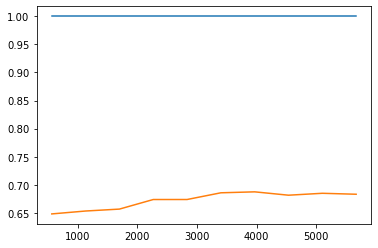

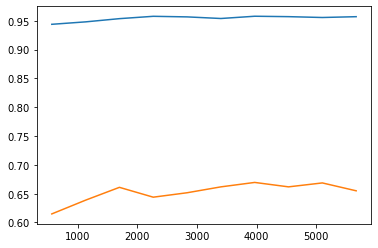

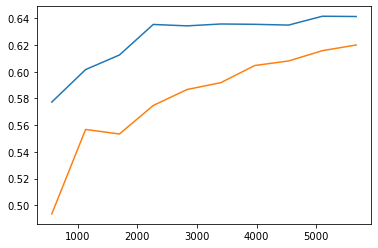

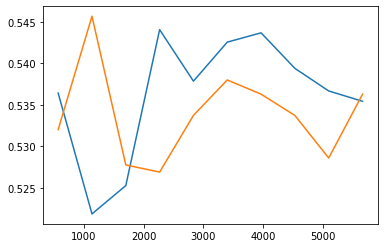

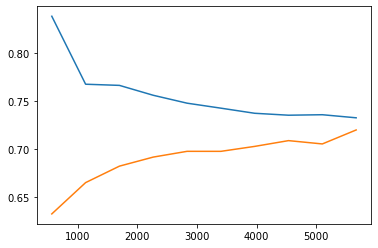

In [789]:
for model in list_model:
    print(model)
    Performance(model)

- Compte tenue du ratios Variables/Lignes,
- Il semble normal que les performance soient mauvaises dans l'ensemble

In [714]:
param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "n_estimators": [100, 200, 500, 1000],
             }
arb = DecisionTreeClassifier(random_state=0)

In [715]:
grid = GridSearchCV(AdaBoostClassifier(arb), param_grid=param_grid, scoring='recall', cv=5)

In [716]:
grid.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(random_state=0)),
             param_grid={'base_estimator__criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 200, 500, 1000]},
             scoring='recall')

In [726]:
meilleur = grid.best_estimator_

In [718]:
grid.best_params_

{'base_estimator__criterion': 'gini', 'n_estimators': 500}

In [719]:
model = grid.best_estimator_

In [728]:
pickle.dump(meilleur, open('Model.sav', 'wb'))

### Inférence

In [745]:
client = {
'Customer_Age':35,
'Gender':'F',
'Dependent_count':5,
'Education_Level':'High School',
'Marital_Status':'Married',
'Income_Category':'Less than $40K',
'Card_Category':'Blue',
'Months_on_book':44,
'Total_Relationship_Count':6,
'Months_Inactive_12_mon':4,
'Contacts_Count_12_mon':3,
'Credit_Limit':15426,
'Total_Revolving_Bal':2540,
'Avg_Open_To_Buy':3542,
'Total_Amt_Chng_Q4_Q1':4.452,
'Total_Trans_Amt':1500,
'Total_Trans_Ct':33,
'Total_Ct_Chng_Q4_Q1':2,
'Avg_Utilization_Ratio':0.076}

In [746]:
client

{'Customer_Age': 35,
 'Gender': 'F',
 'Dependent_count': 5,
 'Education_Level': 'High School',
 'Marital_Status': 'Married',
 'Income_Category': 'Less than $40K',
 'Card_Category': 'Blue',
 'Months_on_book': 44,
 'Total_Relationship_Count': 6,
 'Months_Inactive_12_mon': 4,
 'Contacts_Count_12_mon': 3,
 'Credit_Limit': 15426,
 'Total_Revolving_Bal': 2540,
 'Avg_Open_To_Buy': 3542,
 'Total_Amt_Chng_Q4_Q1': 4.452,
 'Total_Trans_Amt': 1500,
 'Total_Trans_Ct': 33,
 'Total_Ct_Chng_Q4_Q1': 2,
 'Avg_Utilization_Ratio': 0.076}

In [753]:
list_quant
list_cat


def inference(client):
    # données
    d = pd.DataFrame([list(client.values())], columns=list(client.keys()))
    
    # Charger Encoder
    enc = pickle.load(open('encodage.sav', 'rb'))
    
    # Charger Normalisation
    robust = pickle.load(open('normalisation.sav', 'rb'))
    
    # Selection de Variable
    selection = pickle.load(open('Select_Chi2.sav', 'rb'))
    
    #Charger model
    model = pickle.load(open('Model.sav', 'rb'))
    
    #Encodage OneHot
    
    enc_cat = enc.transform(d[list_cat])
    
    d_cat = pd.DataFrame(enc_cat, columns = enc.get_feature_names())
    
    # Normalisation
    d_numeric = d[list_quant].copy()
    
    d_numeric[list_quant] = pd.DataFrame(robust.transform(d[list_quant]), columns=list_quant)
    
    #Concatener donnée finale
    d_final = pd.merge(d_numeric, d_cat, right_index=True, left_index=True)
    
    # Selection de variable Anova/Khi 2
#     var_select = selection.transform(d_final)
    
#     d_ = pd.DataFrame(selection.inverse_transform(var_select), index=d_final.index, columns=d_final.columns)
    
#     list_variable = d_.columns[d_.var() != 0]
    
    var_import = pd.DataFrame(selection.get_support(), d_final.columns).T

    list_variable = []
    for col in var_import:
        if var_import.loc[0, col]:
            list_variable.append(col)
    
    # prediction
    result = model.predict(d_final[list_variable])
    # return the result
    if result == 1:
        return "Est susceptible de se desabonner"
    else:
        return "Ne va pas se désabonner"

In [754]:
inference(client)

'Ne va pas se désabonner'

In [756]:
list_quant = ['Customer_Age','Dependent_count','Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit','Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1','Avg_Utilization_Ratio']
list_cat = ['Marital_Status','Gender','Education_Level','Income_Category','Card_Category']

['Customer_Age',
 'Dependent_count',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

In [758]:
list_cat = ['Marital_Status','Gender','Education_Level','Income_Category','Card_Category']

In [783]:
from pydantic import BaseModel

In [785]:
pd.DataFrame([list(client.values())], columns=list(client.keys()))

Customer_Age Gender  Dependent_count Education_Level Marital_Status  \
0            35      F                5     High School        Married   

  Income_Category Card_Category  Months_on_book  Total_Relationship_Count  \
0  Less than $40K          Blue              44                         6   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                       4                      3         15426   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                 2540             3542                 4.452   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  Avg_Utilization_Ratio  
0             1500              33                    2                  0.076